# Koopman MPC Tutorial

This notebook illustrates how to do use *datafold* to do Koopman-based Model Predictive Control (MPC). We will be using an inverted pendulum, or a cartpole, as a toy model. The first section of this notebook illustrates how to select an EDMD model of our system, as well as possible pitfalls endemic to the data. Then we will use MPC with the trained EDMD model to balance the inverted pendulum in an upright position.


![](cartpole2.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import tqdm.notebook

tqdm.tqdm = tqdm.notebook.tqdm

In [3]:
import inspect
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import utils.plot as plotting
from tqdm import tqdm
from utils.cartpole import CartPole
from utils.data_splits import DataSplits, Trajectory
from utils.edmd import EDMD_RBF, EDMD_Identity, EDMD_Polynomial, EDMD_RBF_v2
from utils.model import Predictions, PredictResult, ScalingAugmenter
from utils.mpc import MPC, MPCConfig

from datafold import EDMD, DMDControl, TSCDataFrame, TSCIdentity, TSCRadialBasis
from datafold.pcfold import InitialCondition

## EDMD

The first step to doing Model Predictive Control (MPC) is to train a good model. Here we will use Extended Dynamic Mode Decomposition (EDMD) to learn the Koopman operator of our model. As a toy model we will use an inverted pendulum, also known as a cartpole in literature.

We start by generating some training and test data using an implentation of a cartpole simulator. The variables of interest for this problem are $x$, $\dot{x} = \frac{d x}{d t}$, $\theta$, and $\dot{\theta} = \frac{d \theta}{d t}$, which are coupled in the nonlinear dynamics of the system. The method for generating data used here is to provide the model a sinusoidal control signal with random amplitude, frequency, and phase.

First we define a function that randomly generates an initial condition in the state space of the inverted pendulum, sampling from an interval given by `ranges`

In [4]:
def rand_ic(ranges, columns=None):
    """Generate a random initial condition inside specified ranges"""
    if columns is None:
        columns = list(ranges)

    n = len(ranges)
    low = np.zeros(n)
    high = np.zeros(n)

    for i, k in enumerate(columns):
        low[i] = ranges[k][0]
        high[i] = ranges[k][1]

    x = np.random.uniform(low, high)
    ic = InitialCondition.from_array(x, time_value=0, feature_names=columns)
    return ic


ranges = {
    "x": [-5, 5],
    "theta": [-np.pi / 4, np.pi / 4],
    "thetadot": [-2.5, 2.5],
    "xdot": [-2.5, 2.5],
}
rand_ic(ranges)

,feature,x,theta,thetadot,xdot
ID,time,,,,
0,0,2.585413,0.536807,-0.606402,0.365596


Next we define a class that provides a sinusoidal control signal to the inverted pendulum. The parameters of the sinusoid (amplitude, frequency, phase) are sampled randomly.

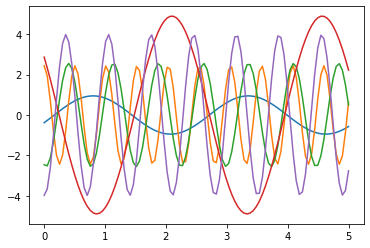

In [5]:
class SineControl:
    """Provide a sinusoidal control function with
    given amplitude, frequency, and phase"""

    def __init__(self, amplitude, frequency, phase):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase = phase

    def __call__(self, t, _):
        return self.amplitude * np.sin(2 * np.pi * (self.frequency * t + self.phase))

    @classmethod
    def new_random(cls):
        amplitude = np.random.uniform(0.1, 5.0)
        frequency = np.random.uniform(1 / 4, 5 / 2)
        phase = np.random.uniform(0, 1)

        return cls(amplitude, frequency, phase)


t = np.linspace(0, 5, 100)

fig = plt.figure()
ax = fig.add_subplot()

for i in range(5):
    controller = SineControl.new_random()
    y = controller(t, None)
    ax.plot(t, y)

Finally, a function to generate a set of trajectories. These trajectories will be used to train and evaluate the EDMD model. The trajectories are generated by the model of the inverted pendulum, given a random initial condition and a random sinusoidal control signal.

In [6]:
def generate_trajectories(model, num_sims, time_step, num_steps, ranges):
    """Generate a random trajectory
    model: model, eg Inverted Pendulum model
    num_sims: number of simulations
    time_step: dt
    num_steps: number of steps per simulation
    ranges: dictionary of limits for initial conditions
    """
    data = []
    for _ in tqdm(range(num_sims)):
        ic = rand_ic(ranges)
        model.reset(ic=ic)
        controller = SineControl.new_random()
        dfx = model.predict(time_step, num_steps, controller)
        dfx.index = dfx["t"]

        data.append((ic, dfx))

    return data


trajectories = generate_trajectories(CartPole(), 1, 0.01, 10, ranges)

fig = plt.figure(figsize=(10, 5))
axes = fig.subplots(2, 3).flatten()
for initial_condition, dfx in trajectories:
    for i, col in enumerate(["x", "xdot", "theta", "theta", "u"]):
        axes[i].plot(dfx[col].values)
        axes[i].set_title(col)

fig.tight_layout()

TypeError: __init__() got an unexpected keyword argument 'initial_condition'

Finally we can generate a set of trajectories. We set the time step `dt = 0.01`, generate 500 time steps per trajectory, and generate 10 trajectories each for a test and train set. The initial conditions are confined to $x \in [-5,5]$, $\dot{x} \in [-2.5, 2.5]$, $\theta \in [-\frac{\pi}{4}, \frac{\pi}{4}]$, and $\dot{\theta} \in [-2.5, 2.5]$

In [ ]:
np.random.seed(0)

# dt in seconds
sim_time_step = 0.01
# number of time steps per simulation
sim_num_steps = 500

# number of simulations for each split
n_train = 10
n_test = 10

ranges = {
    "x": [-5, 5],
    "theta": [-np.pi / 4, np.pi / 4],
    "thetadot": [-2.5, 2.5],
    "xdot": [-2.5, 2.5],
}

# State variables
state_cols = ["x", "xdot", "theta", "thetadot"]
# Control signal
input_cols = ["u"]

# Wrapper for the inverted pendulum model
model = CartPole()

# Generate the data
train_data = generate_trajectories(model, n_train, sim_time_step, sim_num_steps, ranges)

test_data = generate_trajectories(model, n_test, sim_time_step, sim_num_steps, ranges)

splits = DataSplits(train_data, test_data, state_cols, input_cols)
splitsv1 = splits

Below is a plot showing all the generated `train` trajectories and control signals:

In [ ]:
matplotlib.rcParams.update({"font.size": 14})
cols = ["x", "xdot", "theta", "thetadot", "u"]
fig = plt.figure(figsize=(12, 5))
axes = fig.subplots(3, 2).flatten()
plotting.plot_tsc(splitsv1.train_tsc, axes=axes, cols=cols)
fig.tight_layout()

We can visualize the generate trajectories:

In [ ]:
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from utils.cartpole import CartpoleArtist


def animate(df, time_step=sim_time_step):
    fig = plt.figure()
    ax = fig.add_subplot()

    # pick xmin,xmax by looking at range of x values above ^
    xmin = df["x"].min() - 1
    xmax = df["x"].max() + 1
    artist = CartpoleArtist(xmin=xmin, xmax=xmax)

    state = {"x": 0, "theta": np.pi / 4}
    artist.draw(ax, state)

    anim = artist.animate(fig, df)

    ret = HTML(anim.to_jshtml(fps=int(1 / time_step) / 2))
    plt.close(fig)
    return ret


animate(splitsv1.train[0].dfx)

Now let us train an EDMD model on the generated trajectories. Here we use the Identity function in the EDMD dictionary. We train on the `train` split and generate and plot predictions on the `test` split.

In [ ]:
splits = splitsv1


def train_edmd_identity(splits, aug=False):
    edmd = EDMD(
        dict_steps=[
            ("id", TSCIdentity()),
        ],
        dmd_model=DMDControl(),
        include_id_state=False,
    )

    print("Training")
    train_tsc = splits.get_tsc(split="train", aug=aug)
    X = train_tsc[splits.state_cols]
    U = train_tsc[splits.input_cols]
    edmd.fit(X, U=U)

    print("Predicting test set")
    predictions = []
    for traj in tqdm(splits.get_split("test", aug=aug)):
        initial_condition = traj.ic[splits.state_cols]
        control_input = traj.dfx["u"].to_numpy().reshape(-1, 1)
        time = traj.dfx["t"]
        pred = edmd.predict(initial_condition, U=control_input, time_values=time)

        pred = PredictResult(
            control_input,
            initial_condition,
            pred,
            splits.state_cols,
            splits.input_cols,
            traj=traj,
        )
        predictions.append(pred)

    predictions = Predictions(predictions, splits.state_cols)

    return edmd, predictions


edmd, predictions = train_edmd_identity(splits)
fig, axes = predictions.plot(n=5)
fig.tight_layout()

The predictions appear to be very good for $x$ and $\dot{x}$, but very poor for $\theta$ and $\dot{\theta}$.

We can try to fix this with a number of tools. The first is to rescale all the variables so they have a similar magnitude, and shift them to center on 0. We can also try different functions in the EDMD dictionary. Here we used the identity function, but we can also try for example a polynomial functions or radial basis functions in the dictionary.

Let's try again and rescale all the state variables so they have a mean of zero and a standard deviation of 1.

In [ ]:
augmenter = ScalingAugmenter.new(splitsv1.train_tsc)

cols = ["x", "xdot", "theta", "thetadot"]
n = len(cols)
m = 2
fig = plt.figure(figsize=(6 * m, 2 * n))
axes = fig.subplots(n, m)

dfx = splitsv1.train_tsc
dfx_a = augmenter.augment(dfx)

for i, col in enumerate(cols):
    axes[i, 0].plot(dfx[col].values)
    axes[i, 1].plot(dfx_a[col].values)
    axes[i, 0].set_ylabel(col)


axes[0, 0].set_title("Original")
axes[0, 1].set_title("Augmented")

for ax in axes.flatten():
    ax.grid()


fig.tight_layout()

The figure above shows what happens when we augment our training data by rescaling and shifting so the mean is zero and the standard deviation is 1.

The next block shows what happens when we train EDMD with an identity dictionary on the rescaled data.

In [ ]:
splits = splitsv1
splits.init_augment()

edmd, predictions = train_edmd_identity(splits, aug=True)
fig, axes = predictions.plot(n=5)
fig.tight_layout()

We can see that the predictive performance here is still rather poor for $\theta$ and $\dot{\theta}$. Let us next try an additional layer of augmentations. We could argue that it should be easier for the model to capture the dynamics of $\theta$ if it is trained on $\sin(\theta)$. So in the next cell we define an augmenter that computes $\sin(\theta)$ and $\frac{d}{dt} \sin(\theta) = \cos(\theta) \dot{\theta}$, in addition to applying the scaling operation.

In [ ]:
class CartpoleAugmenter(ScalingAugmenter):
    @classmethod
    def new(cls, dfx: pd.DataFrame):
        aug = cls(0, 1)
        dfx_a = aug.augment(dfx)

        offset, scale = cls._init_params(dfx_a)
        return cls(offset, scale)

    def augment(self, state):
        state = state.copy()
        if "theta" in state:
            state["sin"] = np.sin(state["theta"])

            if isinstance(state, dict):
                state["dsin"] = state["thetadot"] * np.cos(state["theta"])
            elif isinstance(state, pd.DataFrame):
                state["dsin"] = state["thetadot"].values * np.cos(state["theta"].values)
        return super().augment(state)

    def deaugment(self, state):
        state = super().deaugment(state)

        if "sin" in state:
            sin = state["sin"]
            dsin = state["dsin"]

            th = np.arcsin(sin).values
            state["theta"] = th
            state["thetadot"] = dsin.values / (1 - sin * sin).values

        return state


class CartpoleSplits(DataSplits):
    def _make_augmenter(self):
        return CartpoleAugmenter.new(self.train_tsc)


augmenter = CartpoleAugmenter.new(splitsv1.train_tsc)

dfx = splitsv1.train_tsc
dfx_a = augmenter.augment(dfx)

cols = ["x", "xdot", "u", "theta", "sin", "dsin"]
N = len(cols)
m = 3
n = int(np.ceil(N / m))
fig = plt.figure(figsize=(6 * m, 2 * n + 0.5))
axes = fig.subplots(n, m).flatten()

for i, col in enumerate(cols):
    axes[i].plot(dfx_a[col].values)
    axes[i].set_title(col)

fig.suptitle("Augmented Training Data")
fig.tight_layout()

In [ ]:
state_cols = ["x", "xdot", "sin", "dsin"]
splits = CartpoleSplits(splitsv1.train, splitsv1.test, state_cols, input_cols)
print("Augmenting")
splits.init_augment()
splitsv2 = splits

edmd, predictions = train_edmd_identity(splits, aug=True)
fig, axes = predictions.plot(n=5)
fig.tight_layout()

The figure above shows predictions on the test set using EDMD trained with an identity dictionary and on the special augmentation scheme described above. The predictions on $\sin(\theta)$ and $\frac{d}{dt}\sin(\theta)$ are better than they were for $\theta$ and $\dot{\theta}$, but still not great. Let us try using a dictionary of radial basis functions.

The next cell creates a wrapper on EDMD specifically for the RBF dictionary. The centers of the RBFs are selected as the cluster centers of kmeans trained on the training data.

In [ ]:
from sklearn.cluster import KMeans

from datafold.pcfold import GaussianKernel


class EDMD_RBF:
    def __init__(self, num_rbfs, eps, state_cols, input_cols):
        self.num_rbfs = num_rbfs
        self.eps = eps
        self.state_cols = state_cols
        self.input_cols = input_cols

        self.rbf = self._init_rbf()
        self.centers = None
        self.kmeans = None

        self._predictor = self._init_predictor()

    def _init_predictor(self):
        return EDMD(
            dict_steps=[
                ("rbf", self.rbf),
            ],
            dmd_model=DMDControl(),
            include_id_state=True,
        )

    def _init_rbf(self):
        rbf = TSCRadialBasis(
            kernel=GaussianKernel(epsilon=self.eps), center_type="fit_params"
        )
        return rbf

    def _init_centers(self, X_tsc):
        X = X_tsc[self.state_cols + self.input_cols].values
        km = KMeans(n_clusters=self.num_rbfs)
        km.fit(X)

        centers = km.cluster_centers_

        self.kmeans = km
        self.centers = centers
        return centers

    def fit(self, X_tsc: TSCDataFrame):
        cols = self.state_cols + self.input_cols
        X_tsc = X_tsc[cols]
        N = X_tsc.shape[0]

        centers = self._init_centers(X_tsc)

        X = X_tsc[self.state_cols]
        U = X_tsc[self.input_cols]
        self._predictor.fit(X, U=U, rbf__centers=centers[:, :-1])

    def predict(self, initial_conds, control_input, time_values):
        pred = self._predictor.predict(
            initial_conds[self.state_cols],
            U=np.atleast_2d(control_input).T,
            time_values=time_values,
        )

        return PredictResult(
            control_input, initial_conds, pred, self.state_cols, self.input_cols
        )


def train_edmd_rbf(splits, n_rbf, eps, aug=False):
    edmd = EDMD_RBF(n_rbf, eps, splits.state_cols, splits.input_cols)

    print("Training")
    train_tsc = splits.get_tsc(split="train", aug=aug)
    edmd.fit(train_tsc)

    print("Predicting test set")
    predictions = []
    for traj in tqdm(splits.get_split("test", aug=True)):
        initial_condition = traj.ic[splits.state_cols]
        control_input = traj.dfx["u"].values.flatten()
        time = traj.dfx["t"]
        pred = edmd.predict(
            initial_condition, control_input=control_input, time_values=time
        )
        pred.traj = traj

        predictions.append(pred)

    predictions = Predictions(predictions, splits.state_cols)

    return edmd, predictions

In [ ]:
splits = splitsv2
n_rbf = 75
eps = 0.5

edmd, predictions = train_edmd_rbf(splits, n_rbf, eps, aug=True)
fig, axes = predictions.plot(n=5)
fig.tight_layout()

The predictive performance of EDMD with an RBF dictionary is still rather poor on $\sin(\theta)$ and $\frac{d}{dt}\sin(\theta)$. Our next step is to reconsider how the data was generated. It could be that Koopman operator is having difficulty capturing the dynamics of the system along the full domain of the data. 

Our intuition tells us that the dynamics of the system are different when the pendulum is above or below the cart. As we are trying to use MPC to balance an inverted pendulum, let us restrict the data used to train EDMD to only the region where the pendulum is "mostly vertical". As before we will start with a randomly generated initial condition based on a set of intervals defined in `ranges`. However, now we will also stop the simulation when the pendulum leaves these bounds. We continue generating simulations until the total number of time steps in our data set exceeds some threshold.

In [ ]:
class DataGenerator:
    def __init__(self, dt, max_steps, min_steps, ranges):
        self.dt = dt
        self.max_steps = max_steps
        self.min_steps = min_steps
        self.ranges = ranges

    def make_ic(self):
        return rand_ic(self.ranges)

    def generate_trajectory(self):
        while True:
            ic = self.make_ic()
            model = CartPole(ic)

            controller = SineControl.new_random()
            dfx = model.predict(self.dt, self.max_steps, controller)
            dfx.index = dfx["t"]

            idx = self.find_end(dfx)
            if idx >= self.min_steps:
                dfx = dfx.iloc[:idx]
                return ic, dfx

    def find_end(self, dfx):
        columns = list(ranges)
        n = len(ranges)
        low = np.zeros(n)
        high = np.zeros(n)

        for i, k in enumerate(columns):
            low[i] = ranges[k][0]
            high[i] = ranges[k][1]

        dfx = dfx[columns].values

        mask = (dfx < low) | (dfx > high)
        idx = np.where(np.any(mask, axis=1))[0][0]
        return idx

    def generate(self, total_steps):
        count = 0
        data = []
        with tqdm(total=total_steps) as pbar:
            while count < total_steps:
                ic, dfx = self.generate_trajectory()

                data.append(Trajectory(ic, dfx))
                count += dfx.shape[0]
                pbar.update(dfx.shape[0])

        return data

In [ ]:
ranges = {
    "x": [-5, 5],
    "theta": [-np.pi / 4, np.pi / 4],
    "thetadot": [-2.5, 2.5],
    "xdot": [-2.5, 2.5],
}

sim_time_step = 0.01  # s
sim_num_steps = 500  # -

n_train_steps = 5000  # sim_num_steps * n_train
n_test_steps = 500

min_steps = 10

gen = DataGenerator(sim_time_step, sim_num_steps, min_steps, ranges)

train_data = gen.generate(n_train_steps)
test_data = gen.generate(n_test_steps)

state_cols = ["x", "xdot", "sin", "dsin"]
input_cols = ["u"]
splits = CartpoleSplits(train_data, test_data, state_cols, input_cols)
splits.init_augment()
splitsv3 = splits

In [ ]:
cols = ["x", "xdot", "u", "theta", "sin", "dsin"]
m = 3
n = int(np.ceil(len(cols) / m))
fig = plt.figure(figsize=(6 * m, 3 * n + 1))
axes = fig.subplots(m, n).T.flatten()
plotting.plot_tsc(splitsv3.get_tsc("train", aug=True), axes=axes, cols=cols)
fig.suptitle("Augmented Training Data")
fig.tight_layout()

In [ ]:
N = len(splitsv3.train)
idx = max(range(N), key=lambda i: splitsv3.train[i].dfx.shape[0])
print("idx", idx, splitsv3.train[idx].dfx.shape)

dfx = splitsv3.train[idx].dfx
animate(splitsv3.train[idx].dfx)

Now that we have our "small angle" data, let us try to train EDMD again with an identity dictionary and an RBF dictionary.

In [ ]:
splits = splitsv3
edmd, predictions = train_edmd_identity(splits, aug=True)
fig, axes = predictions.plot(n=5)
fig.tight_layout()

In [ ]:
splits = splitsv3
n_rbf = 75
eps = 0.5

edmd, predictions = train_edmd_rbf(splits, n_rbf, eps, aug=True)
fig, axes = predictions.plot(n=5)
fig.tight_layout()

Both predictions look rather good. We can devise a metric to measure the performance of each predictor to be able to compare them. For example, for each trajectory in the test set we can measure the number of time steps before the prediction deviates from the real trajectory by some threshold

In [ ]:
def evaluate_predictions(predictions):
    data = []
    for prediction in predictions.predictions:
        data.append(evaluate_prediction(prediction))

    data = np.array(data)
    data = np.mean(data, axis=0)
    return data


def evaluate_prediction(prediction):
    cols = prediction.state_cols
    pred = prediction.pred[cols]
    real = prediction.traj.dfx[cols]

    diff = pred.values - real.values
    err = diff**2
    err = np.concatenate((err, np.ones((1, err.shape[1])) * np.inf), axis=0)

    err = err.reshape(*err.shape, 1)
    thresholds = np.array([1e-3, 1e-6]).reshape(1, 1, -1)

    mask = err > thresholds
    idx = np.argmax(mask, axis=0)

    return idx

In [ ]:
splits = splitsv3
edmd_ident, pred_ident = train_edmd_identity(splits, aug=True)
edmd_rbf, pred_rbf = train_edmd_rbf(splits, n_rbf, eps, aug=True)

m_ident = evaluate_predictions(pred_ident)
m_rbf = evaluate_predictions(pred_rbf)

data = np.array([m_ident, m_rbf]).reshape(4, 4)
mean = np.mean(data, axis=1)
data = pd.DataFrame(data, columns=splits.state_cols)
data["mean"] = mean
data["threshold"] = [1e-3, 1e-6, 1e-3, 1e-6]
data["method"] = ["identity", "identity", "rbf", "rbf"]
data.sort_values(["threshold", "method"])

So for the metric we devised, we see that the RBF dictionary is better with a $10^{-3}$ threshold, but not for the $10^{-6}$ threshold. This means we can continue using the identity dictionary without significant loss in performance. If we saw a significant difference in performance, we would likely want to do a grid search on the parameters of the RBF dictionary (`n_rbf` and `eps`) to further optimize the model.

In [ ]:
edmd = EDMD_Identity(splits.state_cols, splits.input_cols)
edmd.fit(splits.get_tsc("train", aug=True))

In [ ]:
splits = splitsv3
cols = ["x", "xdot", "theta", "thetadot"]
n = 5
m = len(cols)

fig = plt.figure(figsize=(6 * m, 2.5 * n))
axes = fig.subplots(n, m)
splits.plot(axes=axes, cols=cols, split="test", aug=False, n=n)

model = CartPole()
horizon = 20
aug = splits._augmenter

mpc_state_cols = ["x", "sin"]
edmd_state_cols = ["x", "xdot", "sin", "dsin"]

config = MPCConfig(
    **{
        "state_columns": edmd_state_cols,
        "time_step": sim_time_step,
        # the prediction horizon
        # the number of time steps that MPC predicts over
        "horizon": horizon,
        # The columns that MPC is tuned to
        "qois_columns": ["xdot", "sin", "dsin"],
        # bounds on the state variables
        # note that these bounds are on the **augmented** variables
        "state_bounds": np.array([[100, -100], [100, -100], [100, -100]]),
        # bounds on the input (control) variable
        "input_bounds": np.array([[100, -100]]),
        # weight of costs accumulated in intermediate time steps
        "cost_running": np.array([0.1, 1.0, 0.1]),
        # weight of costs from the last time step
        "cost_terminal": np.array([0.1, 1.0, 0.1]),
        # weight of costs from applying a control signal.
        # We set this to a small number to avoid restricting the MPC controller
        "cost_input": 1e-5,
    }
)


for i in range(n):
    dfx = splits.test[i].dfx
    ic = splits.test[i].ic

    config.horizon = min(horizon, dfx.shape[0] - 1)
    mpc = MPC(edmd, config, splits._augmenter)

    ret = mpc.predict(dfx, ic)

    mpc_pred = ret.actual_trajectory(model)
    edmd_pred = aug.deaugment(ret.pred.pred)
    for j, col in enumerate(cols):
        _ = axes[i, j].plot(mpc_pred[col].values)
        _ = axes[i, j].plot(edmd_pred[col].values)

axes[0, 0].legend(["reference", "mpc predicted (edmd)", "mpc actual (cartpole)"])
fig.tight_layout()

In [ ]:
def IC_from_dict(ic):
    columns = list(ic)
    values = np.array([ic[k] for k in columns])
    return InitialCondition.from_array(values, time_value=0, feature_names=columns)

In [ ]:
config = MPCConfig(
    **{
        "state_columns": edmd_state_cols,
        "qois_columns": ["xdot", "sin", "dsin"],
        "time_step": sim_time_step,
        "horizon": 40,
        "state_bounds": np.array([[2.5, -2.5], [2, -2], [2.5, -2.5]]),
        "input_bounds": np.array([[100, -100]]),
        "cost_running": np.array([0.1, 1.0, 0.1]),
        "cost_terminal": np.array([0.1, 1.0, 0.1]),
        "cost_input": 1e-5,
    }
)
mpc = MPC(edmd, config, splits._augmenter)

aug = splits._augmenter

# define the initial condition
ic = IC_from_dict({"x": 0, "xdot": 0.0, "theta": 0.5, "thetadot": 0.0})
# define the target -- the reference state that the system
# should converge to via MPC
target = IC_from_dict({"xdot": 0, "thetadot": 0, "theta": 0})

# convert the target state into a reference signal for MPC
cols = target.columns
ref = np.ones((config.horizon + 1, len(cols))) * target[cols].values
ref = pd.DataFrame(ref, columns=cols)
ref["t"] = np.arange(ref.shape[0]) * config.time_step
ref_a = aug.augment(ref)

# generate a control signal with MPC
ret = mpc.predict(ref, ic)

# extract prediction data frame
cols = list(target.columns) + ["u"] + ["x"]
pred = aug.deaugment(ret.pred.pred)
pred["u"] = aug.augment({"u": ret.control})["u"]

N = len(cols)
m = 3
n = int(np.ceil(N / m))
fig = plt.figure(figsize=(6 * m, 2.5 * n))
axes = fig.subplots(n, m).flatten()

plotting.plot_trajectory(pred, cols=cols, axes=axes)
plotting.plot_trajectory(ref, axes=axes, cols=cols)

axes[0].legend(["mpc", "reference", "actual"])
for j, col in enumerate(cols):
    if col in ranges:
        axes[j].axhline(ranges[col][0], color="k", linestyle="--", alpha=0.6)
        axes[j].axhline(ranges[col][1], color="k", linestyle="--", alpha=0.6)

fig.tight_layout()

In the cell above, we start  in an initial state with zero velocity and with the pendulum at an angle of 0.5 radians from the vertical. We run MPC with a target state where the cart is stationary, and the pendulum is vertical and stationary. The blue line in the figure shows that trajectory predicted by the EDMD model given the control signal generated by MPC. The cost parameters given to MPC have a strong impact on how MPC generates a control signal. What we wanted was for MPC to move the system towards the desired target state. In the figure we do see this happening, meaning we selected a good set of cost parameters for our goal.


Next we can run MPC in a loop. We will run MPC in a feedback loop with the cartpole model. MPC will generate a control signal with a long prediction horizon. Then the state of the system is updated for one time step of the control signal using the cartpole model. The long prediction horizon helps MPC select a better control signal that moves the system towards the reference signal over multiple time steps.

In [ ]:
def run_mpc_control_loop(mpc, ic, target, loop_steps, step_size):
    model = CartPole()

    # run the control loop
    states, control, _ = mpc.control_loop(
        ic, target, loop_steps, model, step_size=step_size
    )
    df = states.copy()
    df["u"] = np.concatenate([control.flatten(), [np.nan]])

    return df

In [ ]:
step_size = 1
loop_steps = 40
ic = IC_from_dict({"x": 0, "xdot": 2.0, "theta": 0.5, "thetadot": 0.5})
target = IC_from_dict({"xdot": 0, "thetadot": 0, "theta": 0})

config = MPCConfig(
    **{
        "state_columns": edmd_state_cols,
        "qois_columns": ["xdot", "sin", "dsin"],
        "time_step": sim_time_step,
        "horizon": 40,
        "state_bounds": np.array([[100, -100], [100, -100], [100, -100]]),
        "input_bounds": np.array([[100, -100]]),
        "cost_running": np.array([0.2, 1.0, 0.1]),
        "cost_terminal": np.array([0.2, 1.0, 0.1]),
        "cost_input": 1e-1,
    }
)
mpc = MPC(edmd, config, splits._augmenter)
df = run_mpc_control_loop(mpc, ic, target, loop_steps, step_size)
df0 = df

cols = ["x", "xdot", "theta", "thetadot", "u"]
N = len(cols)
m = 2
n = int(np.ceil(N / m))
fig = plt.figure(figsize=(6 * m, 3 * n))
axes = fig.subplots(n, m).flatten()

plotting.plot_trajectory(df, axes=axes, cols=cols)

for j, col in enumerate(cols):
    if col in ranges:
        axes[j].axhline(ranges[col][0], color="k", linestyle="--", alpha=0.6)
        axes[j].axhline(ranges[col][1], color="k", linestyle="--", alpha=0.6)

fig.tight_layout()

In [ ]:
animate(df)

The next two cells show the MPC trajectory given randomly generated initial conditions with the same stationary state as a target

In [ ]:
step_size = 1
loop_steps = 40
n = 5
target = IC_from_dict({"xdot": 0, "thetadot": 0, "theta": 0})

config = MPCConfig(
    **{
        "state_columns": edmd_state_cols,
        "qois_columns": ["xdot", "sin", "dsin"],
        "time_step": sim_time_step,
        "horizon": 40,
        "state_bounds": np.array([[100, -100], [100, -100], [100, -100]]),
        "input_bounds": np.array([[100, -100]]),
        "cost_running": np.array([0.2, 1.0, 0.1]),
        "cost_terminal": np.array([0.2, 1.0, 0.1]),
        "cost_input": 1e-1,
    }
)
mpc = MPC(edmd, config, splits._augmenter)

data = []
for i in range(n):
    ic = rand_ic(ranges)
    df = run_mpc_control_loop(mpc, ic, target, loop_steps, step_size)
    data.append((ic, df))

In [ ]:
cols = ["x", "xdot", "theta", "thetadot", "u"]
n = len(data)
m = len(cols)
fig = plt.figure(figsize=(6 * m, 3 * n))
axes = fig.subplots(n, m)
for i, (ic, df) in enumerate(data):
    plotting.plot_trajectory(df, axes=axes[i, :], cols=cols)

    for j, col in enumerate(cols):
        if col in ranges:
            axes[i, j].axhline(ranges[col][0], color="k", linestyle="--", alpha=0.6)
            axes[i, j].axhline(ranges[col][1], color="k", linestyle="--", alpha=0.6)

fig.tight_layout()

In [ ]:
for ic, df in data:
    display(animate(df))